#Skin Cancer Detection Using ResNet

## Kaggle Dataset

#### Install Kaggle
!pip install -q kaggle

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riadulislamrabbi","key":"e2acb2f662bafcad1f62df025677f860"}'}

## Create a kaggle folder


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset       11KB  2024-09-28 20:21:12           8946        168  1.0              
lainguyn123/student-performance-factors                      Student Performance Factors                         94KB  2024-09-02 10:53:57          37418        654  1.0              
aravinii/house-price-prediction-treated-dataset              House Price Prediction Treated Dataset             295KB  2024-10-15 17:43:54           1134         23  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercis

In [4]:
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other
100% 782M/786M [00:10<00:00, 68.7MB/s]
100% 786M/786M [00:10<00:00, 81.2MB/s]


In [5]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!pip install torchsummary

## Loading Library

In [7]:
# Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import dataset
import torchvision.models as models
from torch.utils.data import DataLoader

#Basic Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from PIL import Image
import matplotlib.image as img
import os
import pandas as pd
from glob import glob
import json

from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
import cv2
from tqdm import tqdm



In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
image_size = 224
batch_size = 32
num_workers = 2
learning_rate = 1e-4
num_epoch = 10

### Data Access and Analysis

In [10]:
train_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

## Train Data

In [11]:
trainData = torchvision.datasets.ImageFolder(train_dir, transform=transforms.Compose([transforms.Resize((image_size, image_size)),

                                                                                        transforms.RandomAffine(degrees=(-180, 180), translate=(0.1,0.3), scale=(0.05,0.15)),
                                                                                        transforms.ToTensor()]))

In [12]:
train_loader = torch.utils.data.DataLoader(trainData, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

In [13]:
# Function to count samples per class
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

In [14]:
label_count = count_samples_per_class(trainData)
num_classes = len(label_count)
print("Total number of data: ", len(trainData))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  2239
Number of classes: 9
Number of data samples per class: Counter({5: 462, 3: 438, 1: 376, 4: 357, 7: 181, 8: 139, 0: 114, 2: 95, 6: 77})


In [15]:
class_names = trainData.classes
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


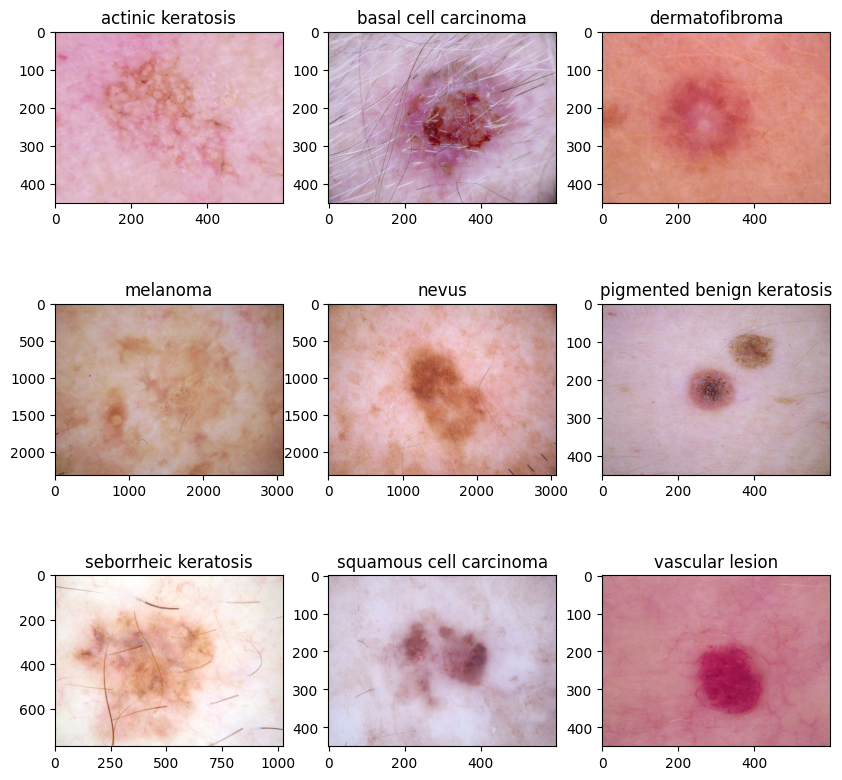

In [16]:
num_classes = len(class_names)
plt.figure(figsize=(10, 10))

for i in range(num_classes):
    plt.subplot(3, 3, i + 1)
    # Find the path to the class folder
    class_folder = os.path.join(trainData.root, class_names[i])
    # Get a list of image files in the class folder
    image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpg')]
    # Read and display the first image in the class folder (if any)
    if image_files:
        image_path = os.path.join(class_folder, image_files[0])
        image = img.imread(image_path)
        plt.title(class_names[i])
        plt.imshow(image)
    else:
        print(f"No images found for class: {class_names[i]}")

# TEST DATA

In [17]:
testData = torchvision.datasets.ImageFolder(test_dir, transform=transforms.Compose([transforms.Resize((image_size, image_size)),

                                                                                        transforms.RandomAffine(degrees=(-180, 180), translate=(0.1,0.3), scale=(0.05,0.15)),
                                                                                        transforms.ToTensor()]))

In [18]:
test_loader = torch.utils.data.DataLoader(testData, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

In [19]:
label_count = count_samples_per_class(testData)
num_classes = len(label_count)
print("Total number of data: ", len(testData))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  118
Number of classes: 9
Number of data samples per class: Counter({0: 16, 1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 7: 16, 6: 3, 8: 3})


#CNN Model

In [20]:
resnet_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

In [21]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [22]:
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
resnet_model.fc = nn.Linear(512, 102)

In [24]:
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet_model.parameters(), lr=learning_rate)

In [26]:
resnet_model = resnet_model

#Retrain the output layer

In [27]:
for p in resnet_model.parameters():
  p.requires_grad = False

In [28]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [29]:
resnet_model.fc = nn.Linear(512, 102) #by default, requires_grad = True

In [30]:
resnet_model = resnet_model

In [31]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

##Retraining more layers

In [32]:
for n, p in resnet_model.named_parameters():
  print(n)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer2.2.conv1.weight
layer2.2.bn1.weight
layer2.2.bn1.bias
layer2.2.conv2.weight
layer2.2.bn2.weight
layer2.2.bn2.bias
layer2.3.conv1.weight
layer2.3.bn1.weight
layer2.3.bn1.bias
layer2.3.conv2.weight
layer2.3.bn2.weight
layer2.3.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight


In [33]:
for p in resnet_model.named_parameters():
  # print(p[0])
  if 'layer4' in p[0]:
    p[1].requires_grad = True

In [34]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [35]:
best_val_accuracy = 0
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images
    labels = labels

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

70it [09:25,  8.07s/it]

Training Loss at epoch 0 is 234.96051955223083
Training Accuracy at epoch 0 is 0.3131048387096774



70it [09:10,  7.87s/it]

Training Loss at epoch 1 is 175.73592114448547
Training Accuracy at epoch 1 is 0.39572292626728106



70it [09:05,  7.80s/it]

Training Loss at epoch 2 is 157.1583948135376
Training Accuracy at epoch 2 is 0.42697292626728106



70it [08:53,  7.62s/it]

Training Loss at epoch 3 is 149.52392256259918
Training Accuracy at epoch 3 is 0.433280529953917



70it [08:52,  7.61s/it]

Training Loss at epoch 4 is 147.65573489665985
Training Accuracy at epoch 4 is 0.4421082949308756



70it [08:50,  7.57s/it]

Training Loss at epoch 5 is 142.43484342098236
Training Accuracy at epoch 5 is 0.4430875576036866



70it [08:58,  7.69s/it]

Training Loss at epoch 6 is 142.7073689699173
Training Accuracy at epoch 6 is 0.4394873271889401



70it [09:39,  8.28s/it]

Training Loss at epoch 7 is 135.38218712806702
Training Accuracy at epoch 7 is 0.4523905529953917



70it [09:01,  7.73s/it]

Training Loss at epoch 8 is 135.61837542057037
Training Accuracy at epoch 8 is 0.4462701612903226



70it [08:59,  7.71s/it]

Training Loss at epoch 9 is 133.96056067943573
Training Accuracy at epoch 9 is 0.4528801843317973


In [38]:
test_running_loss = 0.0
test_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(test_loader):


  images, labels = data
  images = images
  labels = labels

  pred = resnet_model(images)

  loss = loss_fn(pred, labels)

  test_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  test_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  if idx == 10:
    break

print(f"Test Loss is {test_running_loss}")
print(f"Test Accuracy is {test_running_accuracy/(idx+1)}")

Test Loss is 11.718827724456787
Test Accuracy is 0.21448863636363635


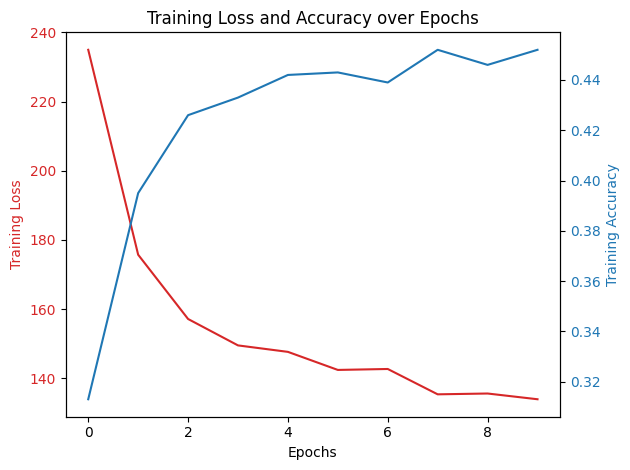

In [40]:
# Data from your training output
epochs = list(range(10))  # Assuming 10 epochs
training_loss = [
  234.960, 175.735, 157.158, 149.523, 147.655, 142.434, 142.707, 135.382, 135.618, 133.960
]
training_accuracy = [
   0.313, 0.395, 0.426, 0.433, 0.442, 0.443, 0.439, 0.452, 0.446, 0.452
]

# Create a figure with two subplots
fig, ax1 = plt.subplots()

# Plot training loss
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(epochs, training_loss, color=color, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for training accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Training Accuracy', color=color)
ax2.plot(epochs, training_accuracy, color=color, label='Training Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustments
plt.title('Training Loss and Accuracy over Epochs')
fig.tight_layout()
plt.show()